In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vegas
from constants import *
import multiprocessing as mp

In [2]:
#from geometry import getRprime,getd,getD,getCosPsi
#from crossSection import getVelocity,getMomentum,diffCrossSectionNuDM,totalCrossSectionDMe,dEv,getEv,maxPsi,maxtheta
from supernovaNuBoostedDM import *

In [3]:
def dnv(D,Ev,Lv = Lv,tau = 10):
    """
    Neutrino number density per energy at d
    
    Input
    ------
    Enu: Neutrino energy in MeV
    D: Distance from the boosted point to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s
    tau: duration of the SN explosion
    
    Output
    ------
    Neutrino flux at d: # per Enu per cm**3
    """
    Lv = Lv*erg2MeV*tau
    D = D*kpc2cm
    
    # Fermi dirac distribution
    def _fv(Ev,Tv):
        exponent = Ev/Tv - 3
        return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    luminosity = Lv/(4*np.pi*D**2*lightSpeed)
    return luminosity*(nue_dist+nueb_dist+4*nux_dist)


def nx(r,mx):
    """
    DM halo number density at r in MW
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    rr=r/24.42
    return (184/mx)/(rr*(1 + rr)**2)

In [4]:
def get_Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame with scattering angle alpha via analytical expression.
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """ 
    sec = 1/np.cos(alpha)
    Enu = (Tx*sec**2+sec*np.sqrt(Tx*(2*mx+Tx)))/(2-Tx*np.tan(alpha)**2/mx)
    return Enu

def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    s = mx**2+2*Ev*mx
    Ecm = 0.5*(s+mx**2)/np.sqrt(s)
    return Ecm/mx


def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution dndOmega
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """ 
    if 0 <= alpha <= np.pi/2 and Ev > 0:
        gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2
    else:
        dndOmega = 0
    return dndOmega

def dEv_legacy(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


In [88]:
def getJx(Tx,mx,mV,r,D,psi,gV=1,gD=1,tau=10):
    """
    Evaluate the BDM emissivity toward the direction psi at the given boosted point 
    
    Input
    ------
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    r: distance from boosted point to GC for calculating DM number density, kpc
    D: distance from boosted point to the SN explosion site, kpc
    psi: the BDM scattering angle, rad
    gV: DM-neutrino coupling constant, default 1
    gD: DM-DM coupling constant, default 1
    
    Output
    ------
    jx: BDM emissivity at the boosted point, 1/(MeV*cm^3*s*rad)
    """   
    # Get the required Ev
    Ev = getEv(Tx,mx,psi)
    # Get dEv/dTx
    dEvdTx = dEv(Tx,mx,psi) 
    # Get the differential DM-nu scattering cross section
    diffCrox = diffCrossSectionNuDM(Tx,mx,mV,psi,gV,gD)
    # Get the emissivity jx
    jx = lightSpeed*diffCrox*nx(r,mx)*dnv(D,Ev,Lv,tau)*dEvdTx
    return jx
    

def xemissivity_legacy(Tx,mx,r,D,Rstar,cosPsi,sigxv = 1e-45,Re = 8.5,max_Ev = 100,tau = 10):
    """
    Evaluate the BDM emissivity toward the direction psi at the given boosted point 
    (legacy version)
    
    Input
    ------
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    r: distance from boosted point to GC for calculating DM number density, kpc
    D: distance from boosted point to the SN explosion site, kpc
    Rstar: distance from SN to the Earth, kpc
    psi: the BDM scattering angle, rad
    Re: distance from GC to Earth, default 8.5 kpc
    max_Ev: maximum neutrino energy to be searched for, default 100 MeV
    
    Output
    ------
    jx: BDM emissivity at the boosted point, 1/(MeV*cm^3*s*rad)
    """
    psi = np.arccos(cosPsi)
    Ev = get_Ev(Tx,mx,psi)
    if Tx < 2*mx/np.tan(psi)**2:
        # Get dEv/dTx
        dEvdTx =  dEv_legacy(Tx,mx,psi)
        # Get the emissivity jx
        jx = lightSpeed*sigxv*nx(r,mx)*dnv(D,Ev,Lv,tau)*dEvdTx
        return jx
    else:
        # flag is invalid, unphysical inputs
        return 0
        

In [6]:
def diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta,phi,beta,Re=8.5,r_cut=1e-5,gV=1,gD=1,tau=10):
    """
    The differential BDM flux over open angle theta at Earth
    
    Input
    ------
    t: The differential BDM flux at time t, relative to the first SN neutrino
        arriving at Earth
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    mV: Mediator mass, MeV
    Rstar: Distance from Earth to SN, kpc
    theta: The open angle theta
    phi: The azimuthal angle along the Earth-SN axis, rad
    beta: The deviation angle, characterizing how SN deviates the GC, rad
    Re: The distance from Earth to GC, default 8.5 kpc
    r_cut: Ignore the BDM contribution when r' < r_cut, default 1e-5 kpc
    gV: DM-neutrino coupling constant, default 1
    gD: DM-DM coupling constant, default 1
    tau: The duration of SN explosion, default 10 s
    
    Output
    ------
    scalar: The diff. BDM flux at Earth, # per MeV per cm^2 per second per rad
    """
    # Get BDM velocity
    vx = getVelocity(Tx,mx)
    # Get the propagation length of BDM via given t and vx
    d = getd(t,vx,Rstar,theta)
    # Get the required SNv propagation length
    D = getD(d,Rstar,theta)
    # Get the distance between boosted point to GC
    rprime = getRprime(d,Rstar,Re,theta,phi,beta)
    if rprime >= r_cut:
        # Get the BDM scattering angle psi
        psi = np.arccos(getCosPsi(d,Rstar,theta))
        # Evaluate the xemissivity
        jx = getJx(Tx,mx,mV,rprime,D,psi,gV,gD,tau)
        # Jacobian
        J = lightSpeed/((d - Rstar*np.cos(theta))/D + 1/vx)
        # BDM flux
        return J*jx*vx*np.sin(theta)
    else:
        return 0
    
def get_BDMflux_theta_legacy(t,Tx,mx,Rstar,theta,phi,beta,sigxv = 1e-45,Re = 8.5,max_Ev = 100,tau = 10):
    # Get BDM velocity
    vx = getVelocity(Tx,mx)
    # Get the propagation length of BDM via given t and vx
    d = getd(t,vx,Rstar,theta)
    # Get the required SNv propagation length
    D = getD(d,Rstar,theta)
    # Get the distance between boosted point to GC
    rprime = getRprime(d,Rstar,Re,theta,phi,beta)
    if rprime >= 1e-5:
        # Get the BDM scattering angle psi
        cosPsi = getCosPsi(d,Rstar,theta)
        # Evaluate the xemissivity
        jx = xemissivity_legacy(Tx,mx,rprime,D,Rstar,cosPsi,sigxv,Re,max_Ev,tau)
        # Jacobian
        J = lightSpeed/((d - Rstar*np.cos(theta))/D + 1/vx)
        # BDM flux
        return J*jx*vx*np.sin(theta)
    else:
        return 0

In [17]:
maxtheta?

Object `maxtheta` not found.


In [9]:
Rstar = 8.5
Tx = 10
mx = 1
mV = mx/3
theta_ls = np.logspace(-2,np.log10(np.pi/2),20)
phi_ls = np.linspace(0,2*np.pi,20)
bdmflux_legacy = []
time_ls = np.logspace(np.log10(yr2s)-3,np.log10(yr2s)+2.3,10)
i = 1
for t in time_ls:
    def f(x):
        theta = x[0]
        return 2*np.pi*get_BDMflux_theta_legacy(t,Tx,mx,Rstar,theta,0,0)
        #if ~np.isnan(flux):
        #    return flux
        #else: return 0
    integ = vegas.Integrator([[0, np.pi]])
    result = integ(f,nitn=10,neval=1000)
    bdmflux_legacy.append(result.mean)
    print(i,end='\r')
    i+=1

/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_58665/2930311937.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))


Text(0.5, 1.0, '$T_\\chi =$10 MeV, $m_\\chi = $1 keV and $\\sigma_{\\chi\\nu}=10^{-45}$ cm$^2$')

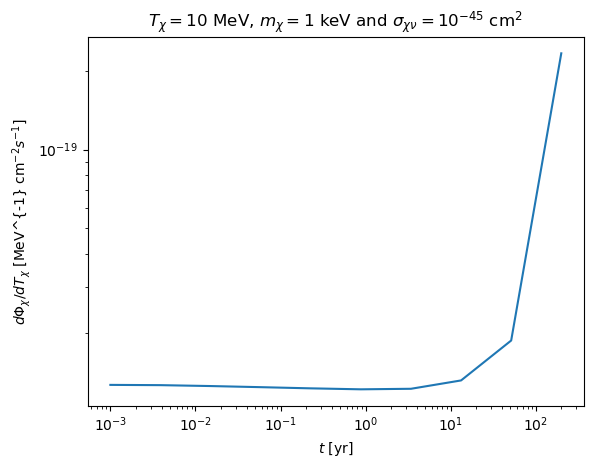

In [14]:
plt.plot(time_ls/yr2s,bdmflux_legacy)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV^{-1} cm$^{-2} s^{-1}$]')
plt.title(r'$T_\chi =$'+str(Tx) +r' MeV, $m_\chi = $' + str(mx)+ r' keV and $\sigma_{\chi\nu}=10^{-45}$ cm$^2$')
#plt.ylim(1e-19,1e-12)

In [10]:
Rstar = 8.5
Tx = 10
mx = 1e-2
mV = mx/3
theta_ls = np.logspace(-5,np.log10(np.pi/2),50)
phi_ls = np.linspace(0,2*np.pi,20)
bdmflux = []
time_ls = np.logspace(np.log10(yr2s)-3,np.log10(yr2s)+1,10)
integ = vegas.Integrator([[0, np.pi]])
i = 1
for t in time_ls:
    # Target function
    def f(x):
        theta = x[0]
        return 2*np.pi*diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta,0,0)
    # Setup integrand for vegas
    result = integ(f,nitn=10,neval=2000)
    bdmflux.append(result.mean)
    print(i,end='\r')
    i+=1

/var/folders/dr/w2wmjyk173551q0j44jf3fnr0000gn/T/ipykernel_95347/2930311937.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))


/Users/yenhsun/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)


(1000000.0, 115350363249227.06)

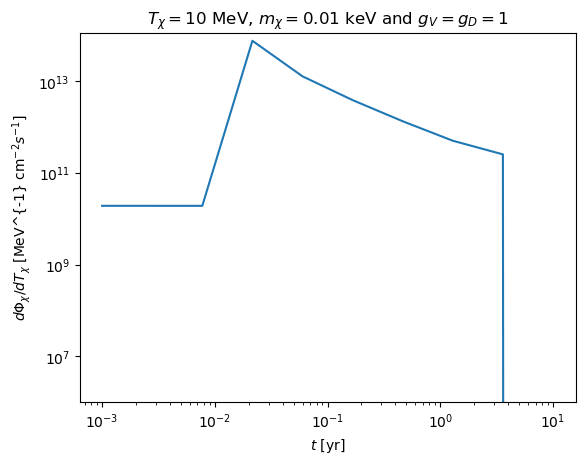

In [11]:
plt.plot(time_ls/yr2s,np.array(bdmflux))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV^{-1} cm$^{-2} s^{-1}$]')
plt.title(f'$T_\chi = {Tx}$ MeV, $m_\chi = {mx}$ keV and $g_V=g_D=1$')
plt.ylim(1e6,)

In [97]:
#theta_ls = np.logspace(-5,np.log10(np.pi/2),50)
#phi_ls = np.linspace(0,2*np.pi,20)
gV = 1e-6
gD = 1e-6
event = []
event_t_bound = []
mx_ls = np.logspace(-6,1,30)
#time_ls = np.logspace(np.log10(yr2s)-3,np.log10(yr2s)+1,100)

i = 1
for mx in mx_ls:
    mV = mx/3
    # Target function
    def f(x):
        t = x[0]
        Tx = x[1]
        theta = x[2]
        return 2*np.pi*diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta,1.45,0,gV=gV,gD=gD)
    # Setup integrand for vegas
    tvan,thetaM = get_tvan_thetaM(5,mx,Rstar)
    if tvan > 35*yr2s: tvan2 = 35*yr2s
    else: tvan2 = tvan
    integ = vegas.Integrator([[0,tvan],[5,100],[0, thetaM]])
    #integ2 = vegas.Integrator([[5,tvan2],[5,100],[0, thetaM]])

    #integ = vegas.Integrator([[0,100*yr2s],[5,100],[0, np.pi]])
    result = integ(f,nitn=10,neval=10000)
    #result2 = integ2(f,nitn=10,neval=10000)
    event.append(result.mean)
    #event_t_bound.append(result2.mean)
    print(i,end='\r')
    i+=1

/Users/yenhsun/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)
/Users/yenhsun/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py:152: RuntimeWarning: invalid value encountered in double_scalars
  d = (zeta - Rstar*vx*cosTheta - np.sqrt((Rstar**2 - zeta**2)*(1 - vx**2) + (Rstar*vx*cosTheta - zeta)**2))*vx/(1-vx**2)
/var/folders/dr/w2wmjyk173551q0j44jf3fnr0000gn/T/ipykernel_95347/2930311937.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))
/Users/yenhsun/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py:119: RuntimeWarning: invalid value encountered in sqrt
  cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)
/Users/yenhsun/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py:130: RuntimeWarning: invalid value encountered in sqrt
  rp2 = ell2*cosIota**2 + (np.sqrt(ell2)*sinI

/Users/yenhsun/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py:59: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(D2)


Text(0, 0.5, '$\\int \\frac{d\\Phi_\\chi}{dT_\\chi dt} dT_\\chi dt$')

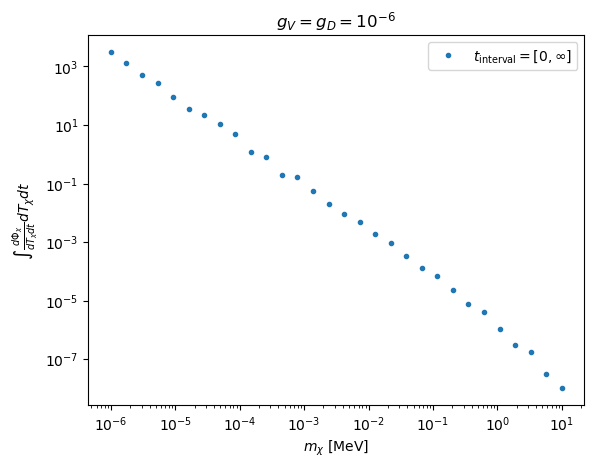

In [101]:
plt.plot(mx_ls,event,'.',label=r'$t_{\rm interval}=[0,\infty]$')
#plt.plot(mx_ls,event_t_bound,'.',label=r'$t_{\rm interval}=[5\,{\rm s},35\,{\rm yrs}]$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$g_V=g_D=10^{-6}$')
plt.legend()
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\int \frac{d\Phi_\chi}{dT_\chi dt} dT_\chi dt$')
#plt.savefig('test.pdf',bbox_inches='tight')

In [100]:
event_t_bound

[2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13,
 2.219288465480109e-13]

In [51]:
?

Signature: diffCrossSectionNuDM(Tx, mx, mV, psi, gV, gD)
Docstring:
Get the differential Nu-DM scattering cross section over psi

Input
------
Tx: BDM kinetic energy
mx: Mass of DM
mV: Mediator mass
psi: Scattering angle
gV: The coupling strength for V-Nu-Nu vertex
gD: The coupling strength for V-DM-DM vertex

Output
------
scalar: differential cross section, cm^2 per rad
File:      ~/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py
Type:      function


In [60]:
Tx = 100
mx_ls = np.logspace(-6,1,8)
crox_ls = []
for mx in mx_ls:
    result = quad(lambda psi: diffCrossSectionNuDM(Tx,mx,mx/3,psi,1,1),0,maxPsi(Tx,mx))
    crox_ls.append(result[0])
crox_ls = np.array(crox_ls)

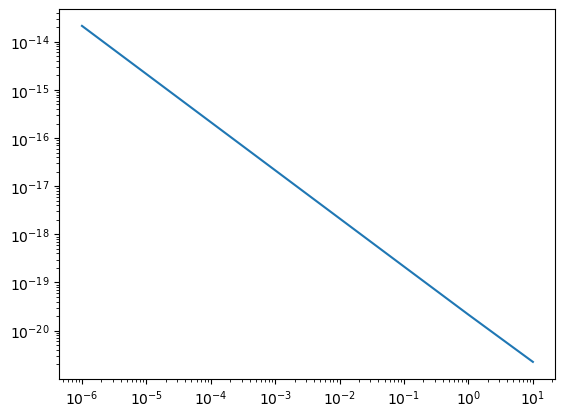

In [61]:
plt.plot(mx_ls,crox_ls)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-30,)

In [62]:
crox_ls

array([2.13287307e-14, 2.13287296e-15, 2.13287322e-16, 2.13288389e-17,
       2.13299106e-18, 2.13406206e-19, 2.14469272e-20, 2.24376358e-21])

In [43]:
ph_ls = np.logspace(-9,np.log10(np.pi/2),100)
Ev_ls = np.linspace(5,100,50)

In [44]:
two_dim = []
ev_1000 = []
ev_100 = []
ev_50 = []
ev_5 = []
for phi in ph_ls:
    #sigxv = diffCrossSectionNuDM(np.cos(phi),Ev,1e-3,1e-3/3,1,1)
    ev_100.append(diffCrossSectionNuDM(np.cos(phi),100,1e-3,1e-3/3,1,1))
    ev_50.append(diffCrossSectionNuDM(np.cos(phi),50,1e-3,1e-3/3,1,1))
    ev_5.append(diffCrossSectionNuDM(np.cos(phi),5,1e-3,1e-3/3,1,1))
    ev_1000.append(diffCrossSectionNuDM(np.cos(phi),1000,1e-3,1e-3/3,1,1))
    

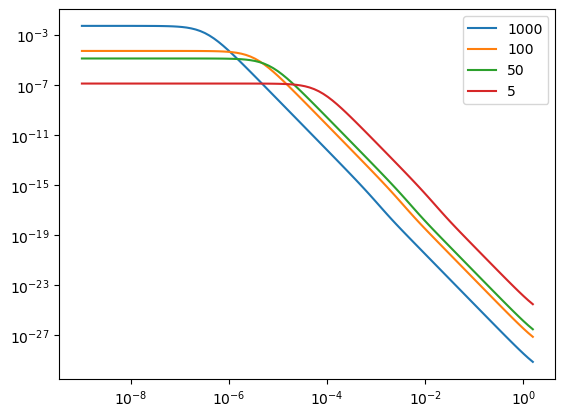

In [45]:
plt.plot(ph_ls,ev_1000,label=1000)
plt.plot(ph_ls,ev_100,label=100)
plt.plot(ph_ls,ev_50,label=50)
plt.plot(ph_ls,ev_5,label=5)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [31]:
Tx = 5
mx = 1e-3
Rstar = 8.5
vx = get_BDMv(Tx,mx)
theta_ls = np.logspace(-9,np.log10(np.pi),100)
t = 1000*yr2s
diffsigxv = []
Ev_ls = []
d_ls = []
D_ls = []
psi_ls =[]
phi_ls =[]
for theta in theta_ls:
    d = get_d(t,vx,Rstar,theta)
    cospsi = get_cosPsi(d,Rstar,theta)
    Ev,cosphi,flag,_ = get_Ev_cosPhi(Tx,mx,cospsi,max_Ev = 100)
    D = get_D(d,Rstar,theta)
    if flag == 'valid':
        sigxv = diffCrossSectionNuDM(cosphi,Ev,mx,mx/3,1,1)*dnv(D,Ev)
    else:
        sigxv = 0
        Ev = 0
    diffsigxv.append(sigxv)
    Ev_ls.append(Ev)
    d_ls.append(d)
    D_ls.append(D)
    psi_ls.append(cospsi)
    phi_ls.append(cosphi)

Text(0.5, 0, '$\\theta$ [$\\pi$]')

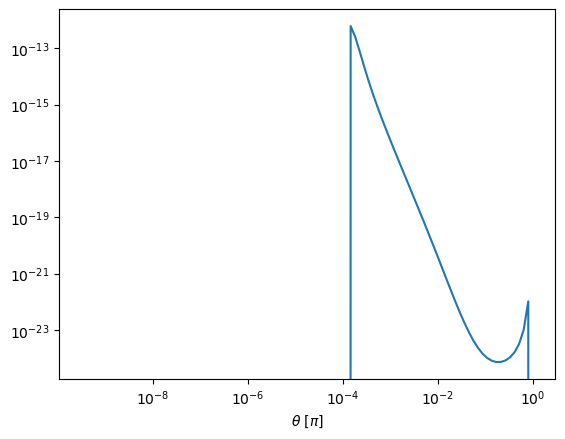

In [13]:
plt.plot(theta_ls/np.pi,diffsigxv)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [$\pi$]')
#plt.xlim(1e-4,)

Text(0.5, 0, '$\\theta$ [$\\pi$]')

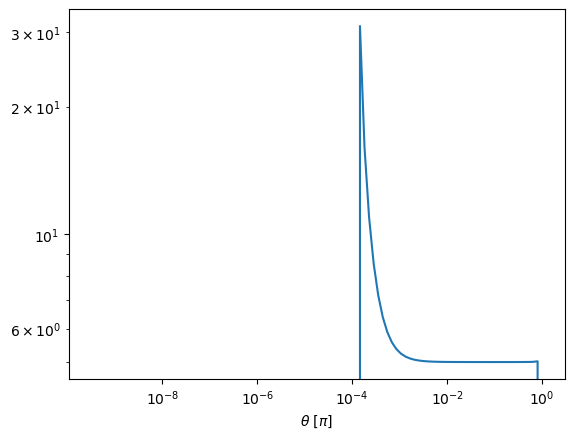

In [14]:
plt.plot(theta_ls/np.pi,Ev_ls)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [$\pi$]')

Text(0.5, 0, '$\\theta$ [$\\pi$]')

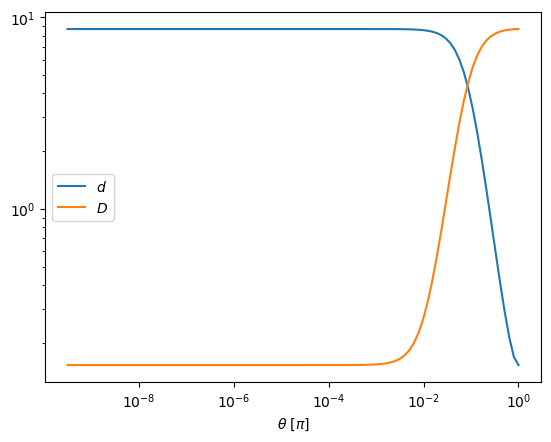

In [15]:
plt.plot(theta_ls/np.pi,d_ls,label='$d$')
plt.plot(theta_ls/np.pi,D_ls,label='$D$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [$\pi$]')

Text(0.5, 0, '$cos\\phi$')

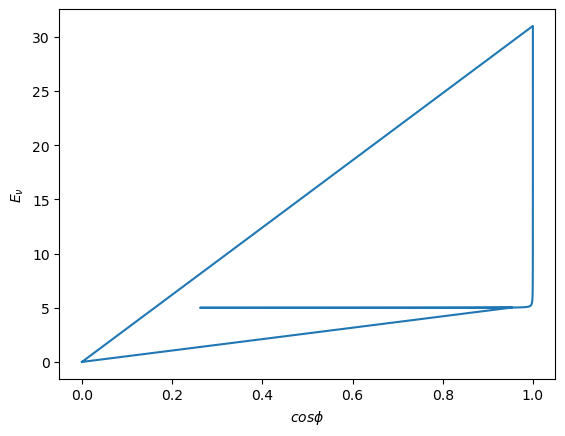

In [39]:
plt.plot(np.nan_to_num(phi_ls),Ev_ls)
#plt.plot(theta_ls/np.pi,np.arccos(phi_ls)/np.pi,label='$\phi$')
#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$E_\nu$')
plt.xlabel(r'$cos\phi$')

In [40]:
Ev_ls

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 31.0163771741714,
 16.03762407454196,
 10.981203525379355,
 8.551139005921813,
 7.19819683828296,
 6.388526644810698,
 5.885836652100548,
 5.56793068384888,
 5.36507910743992,
 5.2351009814751475,
 5.151659646122504,
 5.098048582595748,
 5.06359068717454,
 5.041439185511999,
 5.0271969477597365,
 5.018038120974524,
 5.012145988266618,
 5.008352301633866,
 5.005905696495899,
 5.004323013867105,
 5.003293899618338,
 5.002619552488262,
 5.002173242125985,
 5.001874679802196,
 5.001673303212661,
 5.001537427374679,
 5.001447317235569,
 5.001390874647958,
 5.00136104817693,
 5.00135438604852,
 5.001370403220617,
 5.001411657845706,
 5.001484699316741,
 5.001602527848089,
 5.001790379244661,
 5.002100196520686,
 5.002652125982609,
 5.0037819267879575,
 5.0067

Text(0.5, 0, '$\\theta$ [$\\pi$]')

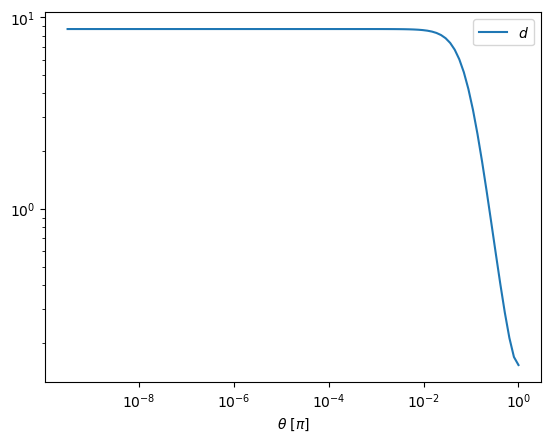

In [20]:
plt.plot(theta_ls/np.pi,d_ls,label='$d$')
#plt.plot(theta_ls/np.pi,D_ls,label='$D$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [$\pi$]')

In [20]:
np.arccos(-1)

3.141592653589793

In [17]:
np.isnan(phi_ls[2])

True

In [21]:
True and False

False